Code for each part is typed in individual cells. Following all the code cells are my written responses. 

In [ ]:
import csv
import random
import math

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors using the given formula."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Generates a new book sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence

def hill_climbing(book_list, max_iterations=10000):
    """Implements the Hill Climbing algorithm to minimize the total color distance."""
    books = list(book_list.keys())
    current_sequence = random.sample(books, len(books))  # Start with a random order
    current_score = total_score(current_sequence, book_list)
    
    for _ in range(max_iterations):
        neighbor = swap_books(current_sequence)
        neighbor_score = total_score(neighbor, book_list)
        
        if neighbor_score < current_score:  # Accept if the new arrangement is better
            current_sequence, current_score = neighbor, neighbor_score
    
    return current_sequence, current_score

# Load book data
book_list = read_books_list("data_book.csv")

# Run Hill Climbing
best_sequence, best_score = hill_climbing(book_list, max_iterations=10000)

# Print results
print("Best sequence found:", best_sequence[:10], "...")  # Show first 10 book IDs
print("Best score:", best_score)


Best sequence found: ['VDA6', 'UJG7', 'LPO3', 'GSB2', 'RPG3', 'KDO10', 'IQR6', 'LIX1', 'LWP3', 'BYR2'] ...
Best score: 171058.88427156027


In [ ]:
# run 20X 
import csv
import random
import math
import multiprocessing

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors using the given formula."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Generates a new book sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence, (i, j)

def hill_climbing(book_list, max_iterations=3000):
    """Optimized Hill Climbing: Minimizes total color distance with incremental scoring."""
    books = list(book_list.keys())
    current_sequence = random.sample(books, len(books))  # Start with a random order
    current_score = total_score(current_sequence, book_list)
    
    for _ in range(max_iterations):
        neighbor, (i, j) = swap_books(current_sequence)
        
        # Compute incremental score update
        prev_score = (colour_distance(book_list[current_sequence[i]], book_list[current_sequence[i-1]]) +
                      colour_distance(book_list[current_sequence[i]], book_list[current_sequence[i+1]]) +
                      colour_distance(book_list[current_sequence[j]], book_list[current_sequence[j-1]]) +
                      colour_distance(book_list[current_sequence[j]], book_list[current_sequence[j+1]]))
        
        new_score = (colour_distance(book_list[neighbor[i]], book_list[neighbor[i-1]]) +
                     colour_distance(book_list[neighbor[i]], book_list[neighbor[i+1]]) +
                     colour_distance(book_list[neighbor[j]], book_list[neighbor[j-1]]) +
                     colour_distance(book_list[neighbor[j]], book_list[neighbor[j+1]]))
        
        neighbor_score = current_score - prev_score + new_score
        
        if neighbor_score < current_score:  # Accept if the new arrangement is better
            current_sequence, current_score = neighbor, neighbor_score
    
    return current_score

def run_multiple_hill_climbings(book_list, num_runs=20):
    """Runs multiple hill climbing iterations in parallel and saves results."""
    with multiprocessing.Pool(processes=4) as pool:  # Use 4 CPU cores
        results = pool.starmap(hill_climbing, [(book_list,)] * num_runs)
    
    # Summarize results
    best_score = min(results)
    worst_score = max(results)
    avg_score = sum(results) / num_runs
    std_dev = math.sqrt(sum((x - avg_score) ** 2 for x in results) / num_runs)
    
    with open("hill_climbing_results.txt", "w") as f:
        for run, score in enumerate(results, 1):
            f.write(f"Run {run}: Score = {score}\n")
        f.write("\nSummary:\n")
        f.write(f"Best Score: {best_score}\n")
        f.write(f"Worst Score: {worst_score}\n")
        f.write(f"Average Score: {avg_score}\n")
        f.write(f"Standard Deviation: {std_dev}\n")
    
    print("Results saved to hill_climbing_results.txt")

# Load book data
book_list = read_books_list("data_book.csv")

# Run optimized hill climbing multiple times in parallel
run_multiple_hill_climbings(book_list, num_runs=20)

Process SpawnPoolWorker-3:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
Process SpawnPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py", line 387, in get
   

Matplotlib is building the font cache; this may take a moment.


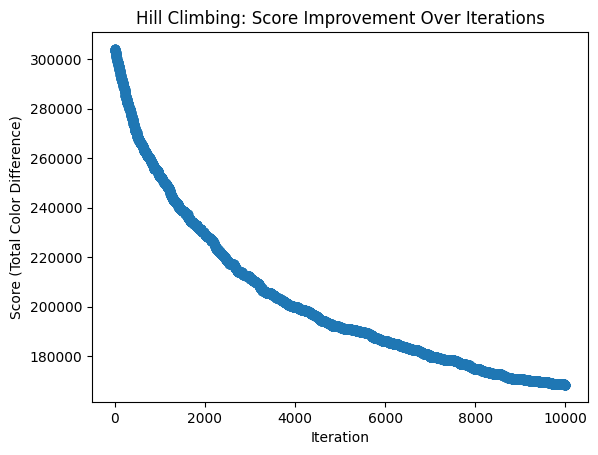

Best sequence found: ['QWC3', 'LQG2', 'VSG7', 'SHT8', 'APN6', 'ZBO1', 'VDA6', 'DXK5', 'OBR4', 'HQU1'] ...
Best score: 168294.67724141548


In [1]:
# visualization code for part c 
import csv
import random
import math
import matplotlib.pyplot as plt

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Generates a new book sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence

def hill_climbing(book_list, max_iterations=10000):
    """Implements the Hill Climbing algorithm to minimize the total color distance and tracks score progression."""
    books = list(book_list.keys())
    current_sequence = random.sample(books, len(books))  # Start with a random order
    current_score = total_score(current_sequence, book_list)
    scores = [current_score]
    
    for _ in range(max_iterations):
        neighbor = swap_books(current_sequence)
        neighbor_score = total_score(neighbor, book_list)
        
        if neighbor_score < current_score:  # Accept if the new arrangement is better
            current_sequence, current_score = neighbor, neighbor_score
        scores.append(current_score)
    
    return current_sequence, current_score, scores

# Load book data
book_list = read_books_list("data_book.csv")

# Run Hill Climbing and track scores
best_sequence, best_score, score_progression = hill_climbing(book_list, max_iterations=10000)

# Plot the score progression
plt.plot(range(len(score_progression)), score_progression, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Score (Total Color Difference)")
plt.title("Hill Climbing: Score Improvement Over Iterations")
plt.show()

# Print results
print("Best sequence found:", best_sequence[:10], "...")  # Show first 10 book IDs
print("Best score:", best_score)



1. Reading the data: The read_books_list() function loads book informaiton from data_book.csv into a dictionary mapping book IDs to their RGB color values. 
2. Calculating distance: The color_distance() function computes the total color difference between adjacent books in a given order. 
3. Evaluation: The total_score() function computes the total color difference between adjacent books in a given order. 
4. Generating Neighboring solution: The swap_books() function randomly selects two books and swaps their positions to create a new ordering.

The Hill Climbing Algorithm starts with a random book arrangement, iteratively swaps books and accepts only better arrangements, then returns the best-found sequence and its score after the specified number of iterations.

1.3 Exploration 
(a) 
Best sequence found: ['VDA6', 'UJG7', 'LPO3', 'GSB2', 'RPG3', 'KDO10', 'IQR6', 'LIX1', 'LWP3', 'BYR2'] ...
Best score: 171058.88427156027
(b) I have included a second code cell to run 20 times and store the results in a text file.
(c)
Based on the generated graph the score drops sharply, meaning the algorithm is finding good swaps quickly.The score flattens, meaning the algorithm isn’t finding much better swaps.At this point, most beneficial swaps have already been made, and it's struggling to improve further.

Hill Climbing is a fast and simple optimization algorithm, but its effectiveness depends on the problem. In our case of sorting books by color similarity, it has some limitations. Hill Climbing stops when no immediate improvement is found, even if a much better arrangement exists further away. Since our score values are still quite high, this suggests that the algorithm is getting stuck in a suboptimal solution rather than finding the best one. To optimize the algorithm we could do several things: 
- Instead of starting once and stopping, restart multiple times with a different initial book order (Run HC 10+ times and keep the best result)
- Simulated Annealing: Instead of only accepting better solutions, sometimes accept worse solutions with a probability that decreases over time
- Instead of swapping only two books, swap multiple at once to explore more diverse configurations.


In [10]:
import csv
import random
import math

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Creates a mutated sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence

def weighted_choice(population, fitness):
    """Selects a sequence from the population with a probability weighted by fitness."""
    total_fitness = sum(fitness)
    probabilities = [f / total_fitness for f in fitness]
    return random.choices(population, weights=probabilities, k=1)[0]

def genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03):
    """Optimized Genetic Algorithm: Faster execution while improving book sorting."""
    books = list(book_list.keys())
    
    # Step 1: Initialize Population (random book sequences)
    population = [random.sample(books, len(books)) for _ in range(population_size)]
    
    for generation in range(generations):
        # Step 2: Evaluate Fitness (lower scores are better)
        fitness_scores = [1 / (1 + total_score(seq, book_list)) for seq in population]
        
        # Step 3: Select top 50% of population
        sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
        population = [x[0] for x in sorted_population[:population_size // 2]]
        
        # Step 4: Mutation on selected individuals to create new population
        new_population = []
        for seq in population:
            mutated_seq = swap_books(seq) if random.random() < mutation_rate else seq
            new_population.append(mutated_seq)
        
        # Duplicate best half to maintain population size
        population.extend(new_population)
    
    # Step 5: Return best sequence found
    best_sequence = min(population, key=lambda seq: total_score(seq, book_list))
    best_score = total_score(best_sequence, book_list)
    return best_sequence, best_score

# Load book data
book_list = read_books_list("data_book.csv")

# Run Optimized Genetic Algorithm
best_sequence, best_score = genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03)

# Print results
print("Best sequence found:", best_sequence[:10], "...")  # Show first 10 book IDs
print("Best score:", best_score)


Best sequence found: ['ZTR7', 'CRQ5', 'DXK5', 'TVO5', 'GWZ2', 'CXQ10', 'CDJ4', 'UGF7', 'FVI4', 'KEV5'] ...
Best score: 299809.5881750599


In [11]:
# genetic w 10X
import csv
import random
import math

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Creates a mutated sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence

def weighted_choice(population, fitness):
    """Selects a sequence from the population with a probability weighted by fitness."""
    total_fitness = sum(fitness)
    probabilities = [f / total_fitness for f in fitness]
    return random.choices(population, weights=probabilities, k=1)[0]

def genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03, num_runs=10):
    """Runs multiple instances of the Genetic Algorithm and saves results."""
    results = []
    for run in range(num_runs):
        books = list(book_list.keys())
        population = [random.sample(books, len(books)) for _ in range(population_size)]
        
        for generation in range(generations):
            fitness_scores = [1 / (1 + total_score(seq, book_list)) for seq in population]
            sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
            population = [x[0] for x in sorted_population[:population_size // 2]]
            new_population = [swap_books(seq) if random.random() < mutation_rate else seq for seq in population]
            population.extend(new_population)
        
        best_sequence = min(population, key=lambda seq: total_score(seq, book_list))
        best_score = total_score(best_sequence, book_list)
        results.append(best_score)
    
    # Write results to file
    with open("genetic_algorithm_results.txt", "w") as f:
        for i, score in enumerate(results, 1):
            f.write(f"Run {i}: Score = {score}\n")
        
        f.write("\nSummary:\n")
        f.write(f"Best Score: {min(results)}\n")
        f.write(f"Worst Score: {max(results)}\n")
        f.write(f"Average Score: {sum(results) / num_runs}\n")
        f.write(f"Standard Deviation: {math.sqrt(sum((x - (sum(results) / num_runs)) ** 2 for x in results) / num_runs)}\n")
    
    print("Results saved to genetic_algorithm_results.txt")

# Load book data
book_list = read_books_list("data_book.csv")

# Run Genetic Algorithm multiple times
genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03, num_runs=10)

Results saved to genetic_algorithm_results.txt


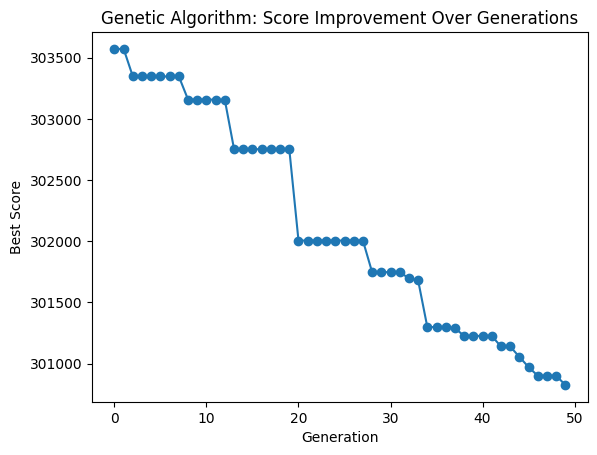

Best sequence found: ['GML4', 'ZWN8', 'CAI1', 'OST5', 'JKE5', 'KZB10', 'VUY8', 'LPO3', 'OPB6', 'LQM8'] ...
Best score: 300826.7367576787


In [2]:
# visulaization for exploration part d 
import csv
import random
import math
import matplotlib.pyplot as plt

def read_books_list(filename):
    """Reads the book data from the CSV file and returns a dictionary mapping book IDs to their RGB colors."""
    books = {}
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            book_id, r, g, b = row[0], int(row[1]), int(row[2]), int(row[3])
            books[book_id] = (r, g, b)
    return books

def colour_distance(c1, c2):
    """Computes the perceptual color distance between two RGB colors."""
    rmean = (c1[0] + c2[0]) / 2.0
    r = c1[0] - c2[0]
    g = c1[1] - c2[1]
    b = c1[2] - c2[2]
    return math.sqrt(((2 + rmean / 256) * r ** 2) + 4 * g ** 2 + ((2 + (255 - rmean) / 256) * b ** 2))

def total_score(sequence, book_list):
    """Computes the total color difference score for a given book sequence."""
    return sum(colour_distance(book_list[sequence[i]], book_list[sequence[i+1]]) for i in range(len(sequence) - 1))

def swap_books(sequence):
    """Creates a mutated sequence by swapping two randomly chosen books."""
    new_sequence = sequence[:]
    i, j = random.sample(range(len(new_sequence)), 2)  # Pick two different indices
    new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
    return new_sequence

def weighted_choice(population, fitness):
    """Selects a sequence from the population with a probability weighted by fitness."""
    total_fitness = sum(fitness)
    probabilities = [f / total_fitness for f in fitness]
    return random.choices(population, weights=probabilities, k=1)[0]

def genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03):
    """Runs the Genetic Algorithm and visualizes the score change over generations."""
    books = list(book_list.keys())
    population = [random.sample(books, len(books)) for _ in range(population_size)]
    best_scores = []
    
    for generation in range(generations):
        fitness_scores = [1 / (1 + total_score(seq, book_list)) for seq in population]
        sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
        population = [x[0] for x in sorted_population[:population_size // 2]]
        new_population = [swap_books(seq) if random.random() < mutation_rate else seq for seq in population]
        population.extend(new_population)
        
        # Track best score for visualization
        best_sequence = min(population, key=lambda seq: total_score(seq, book_list))
        best_scores.append(total_score(best_sequence, book_list))
    
    # Plot the best score improvement
    plt.plot(range(generations), best_scores, marker='o', linestyle='-')
    plt.xlabel("Generation")
    plt.ylabel("Best Score")
    plt.title("Genetic Algorithm: Score Improvement Over Generations")
    plt.show()
    
    return best_sequence, best_scores[-1]

# Load book data
book_list = read_books_list("data_book.csv")

# Run Genetic Algorithm and visualize score improvement
best_sequence, best_score = genetic_algorithm(book_list, population_size=100, generations=50, mutation_rate=0.03)

# Print results
print("Best sequence found:", best_sequence[:10], "...")  # Show first 10 book IDs
print("Best score:", best_score)


The Genetic Algorithm code optimizes the book arrangement by evolving a population of random sequences over multiple generations. Each sequence represents an order of books, and its fitness is determined by the total color difference between adjacent books (lower scores are better). The algorithm starts with a random population, selects the best half based on fitness, and generates new sequences through mutation (swapping books randomly). This process repeats for multiple generations, gradually improving the arrangement. The algorithm tracks the best score over time and visualizes how it improves, helping to analyze its effectiveness compared to Hill Climbing. 

2.3 Exploration 
(a)
Best sequence found: ['ZTR7', 'CRQ5', 'DXK5', 'TVO5', 'GWZ2', 'CXQ10', 'CDJ4', 'UGF7', 'FVI4', 'KEV5'] ...
Best score: 299809.5881750599
(b) I have included a second code cell to run 10 times and store the results in a text file.
(c)
1. Increasing Population Size
This increases computation time because each generation evaluates more individual cases. The algorithm might find better solutions but take longer.
2. Increasing Generations 
More generations allow the Genetic Algorithm to refine solutions further so with more iterations, we expect lower scores (better arrangements). However, too many generations risk overfitting or unnecessary computation.
(d) 
Differences in algorithm approaches: 
HC: 
- Works with a single solution, iteratively improving it
- Only explores neighboring states		
- Faster 
GA: 
- Works with a population of solutions, evolving over time
- Explores multiple solutions  
- Slower
To make the Genetic Algorithm more efficient you could reduce the population size to reduce the number of computations and stop the algorithm if the best score hasn't improved in 10 generations. 
